# XRISM operation seminar

In [1]:
import numpy as np
import skyfield.api
from skyfield.api import load, wgs84
import sgp4.ext
import plotly.express as px
import astropy.time
import astropy.coordinates
from astropy import units as u
from astropy import constants as const
import datetime
#
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
palette=sns.color_palette("hls",16)

# Constants
TIMESCALE: skyfield.api.Timescale = skyfield.api.load.timescale()
MU: np.float64 = np.float64(3.986004418)

# JPL Almanac
eph = load('de421.bsp')
print('Ready')

# Ground stations
stations={
    'USC' : [31.25, 131.8, 0],
    'KTU' : [35.2, 140.3, 0],
    'SNT' : [-33.13, -70.67, 1],
    'MSP' : [27.72, -15.63, 1],
    'MGN' : [-29.194, 115.441, 1],
    'HBK' : [-25.8872, 27.7075, 2],
    'USHI' : [20.706, -156.257, 2],
}

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[#################################] 100% de421.bsp


Ready


## Orbital period

In [2]:
G = const.G
M_earth = const.M_earth
R_earth = const.R_earth

def get_P(h):
    P = np.sqrt(((R_earth + h)**3.0/G/M_earth))*2*np.pi
    return P
def get_v(h):
    P = get_P(h)

    v = (2*np.pi/P) * (R_earth + h)
    return v

hs = np.logspace(2,5,60)
Ps = [get_P(h * u.km).to('min').value for h in hs]
vs = [get_v(h * u.km).to('km/s').value for h in hs]

print(get_P(570 * u.km).to('min'))
print(get_v(570 * u.km).to('km/s'))

96.06359680799295 min
7.574183714994607 km / s


In [3]:
import plotly.express as px

fig=px.line(x=hs, y=Ps, log_x=True, log_y=True, labels={'x': 'Height (km)', 'y':'Period (min)'})
fig.add_vline(575) # XRISM
#fig.add_vline(408) # ISS
fig.add_hline(24*60)
fig.show()

## Projection on Earth

In [4]:
# Time span.
def get_span(datetime_start, datetime_end, tstep):
    span = [datetime_start]
    while span[-1] < datetime_end:
        span.append(span[-1] + datetime.timedelta(seconds=tstep))
    return span

# Get TLE
def get_tle(norad_num):
    url = 'https://celestrak.org/NORAD/elements/gp.php?CATNR={}'.format(norad_num)
    filename = 'tle-CATNR-{}.txt'.format(norad_num)
    satellite = skyfield.api.load.tle_file(url, filename=filename)
    return satellite[0]

# Projected point
def get_lonlat(satellite, datetime_start, datetime_end, tstep, cstep):
    span=get_span(datetime_start, datetime_end, tstep)
    geocentric = [satellite.at(TIMESCALE.utc(_span)) for _span in span]
    lat = np.array([wgs84.latlon_of(_geocentric)[0].degrees for _geocentric in geocentric])
    lon = np.array([wgs84.latlon_of(_geocentric)[1].degrees for _geocentric in geocentric])
    colors=[palette[int(tstep/cstep*i//1)%len(palette)] for i in range(len(lat))]
    return lon, lat, colors

# Plot map
def plot_map(norad_num, datetime_start, datetime_end, tstep, cstep):

    satellite=get_tle(norad_num)
    lon, lat, colors = get_lonlat(satellite, datetime_start, datetime_end, tstep, cstep)

    plt.figure(figsize=(24,24))
    map = Basemap(projection='merc', llcrnrlon=-180, urcrnrlon=180, llcrnrlat=-60, urcrnrlat=60)
    map.drawcoastlines()
    map.drawparallels([-60,-30,0,30,60],labels=[1,1,1,1,1])
    map.drawparallels([0],labels=[1])
    map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
    map.drawmapboundary(fill_color='none')
    map.fillcontinents(color='none',lake_color='none')
    plt.title("{} to {} (1 color for {} hr)".format(datetime_start, datetime_end, int(cstep/3600)))

    # Orbits
    lonlat_proj = np.array([map(_lon, _lat) for _lon, _lat in zip(lon, lat)])
    map.scatter(lonlat_proj[:,0], lonlat_proj[:,1], marker = '.', color=colors, zorder=5)

    plt.savefig('./lonlat{}.pdf'.format(norad_num))
    plt.show()

In [5]:
# XRISM
datetime_start=datetime.datetime(2024,1,23,0,0,0, tzinfo=datetime.timezone.utc)
datetime_end=datetime.datetime(2024,1,24,0,0,0, tzinfo=datetime.timezone.utc)
tstep=10.0 # seconds
cstep=60*60 # seconds
norad_num=57800
plot_map(norad_num, datetime_start, datetime_end, tstep, cstep)

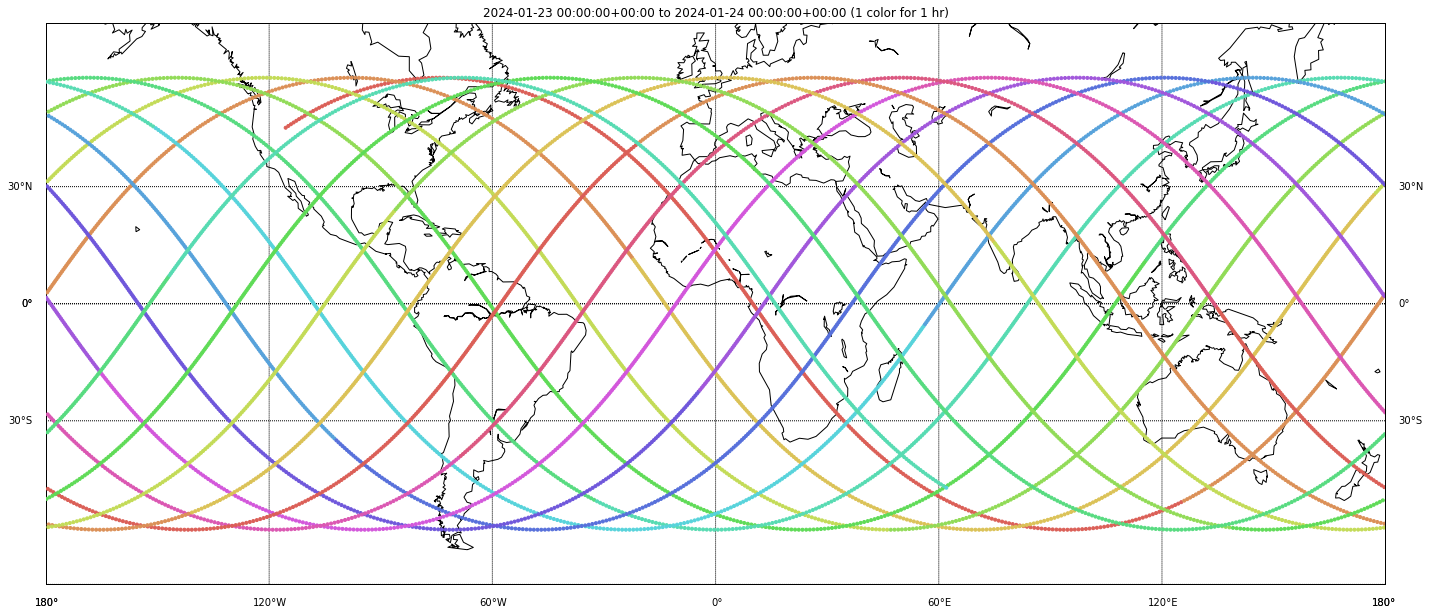

In [6]:
# ISS
datetime_start=datetime.datetime(2024,1,23,0,0,0, tzinfo=datetime.timezone.utc)
datetime_end=datetime.datetime(2024,1,24,0,0,0, tzinfo=datetime.timezone.utc)
tstep=10.0 # seconds
cstep=60*60 # seconds
norad_num=25544
plot_map(norad_num, datetime_start, datetime_end, tstep, cstep)

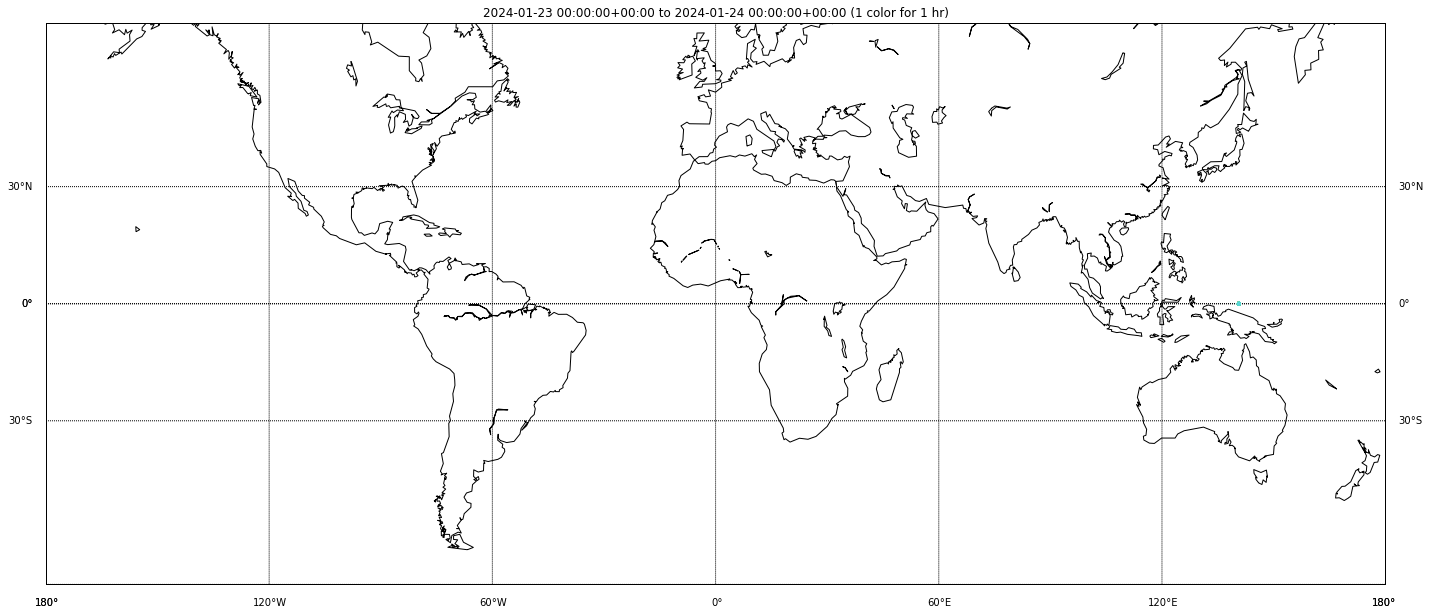

In [7]:
# Himawari-9
datetime_start=datetime.datetime(2024,1,23,0,0,0, tzinfo=datetime.timezone.utc)
datetime_end=datetime.datetime(2024,1,24,0,0,0, tzinfo=datetime.timezone.utc)
tstep=10.0 # seconds
cstep=60*60 # seconds
norad_num=41836
plot_map(norad_num, datetime_start, datetime_end, tstep, cstep)

In [8]:
# Michibiki-4
datetime_start=datetime.datetime(2024,1,23,0,0,0, tzinfo=datetime.timezone.utc)
datetime_end=datetime.datetime(2024,1,24,0,0,0, tzinfo=datetime.timezone.utc)
tstep=30.0 # seconds
cstep=60*60 # seconds
norad_num=42965
plot_map(norad_num, datetime_start, datetime_end, tstep, cstep)

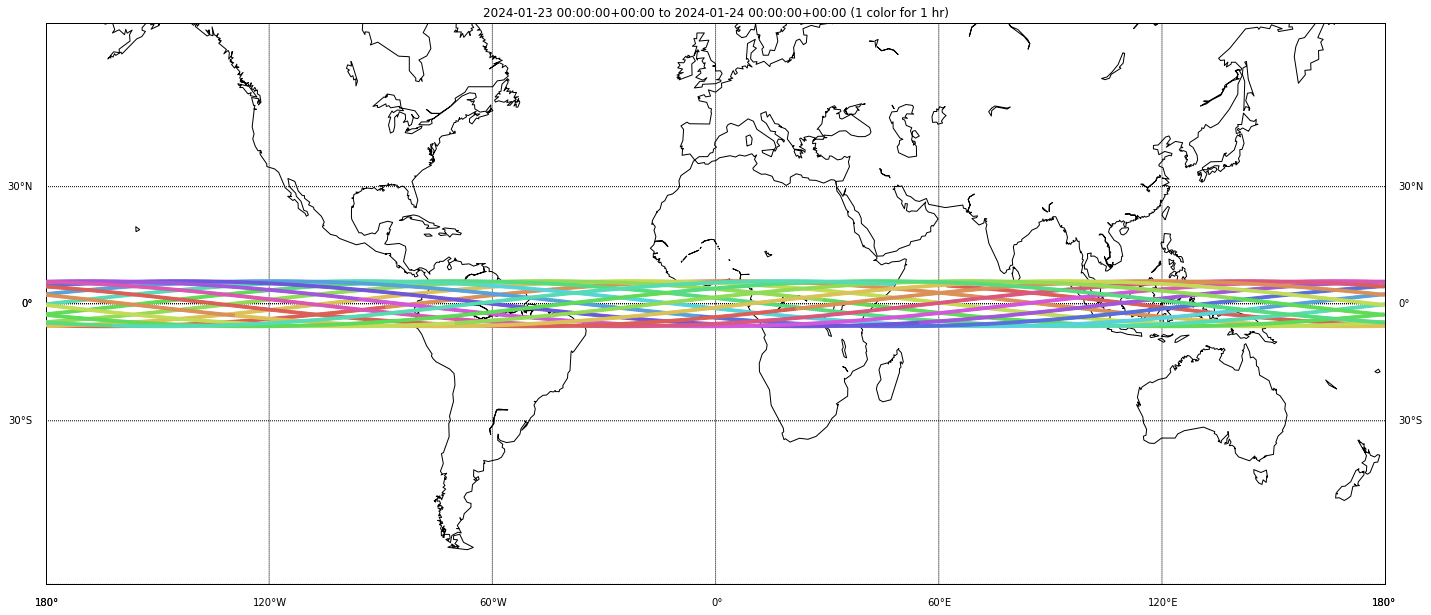

In [9]:
# NuSTAR
datetime_start=datetime.datetime(2024,1,23,0,0,0, tzinfo=datetime.timezone.utc)
datetime_end=datetime.datetime(2024,1,24,0,0,0, tzinfo=datetime.timezone.utc)
tstep=10.0 # seconds
cstep=60*60 # seconds
norad_num=38358
plot_map(norad_num, datetime_start, datetime_end, tstep, cstep)

In [10]:
# XMM-Newton
datetime_start=datetime.datetime(2024,1,23,0,0,0, tzinfo=datetime.timezone.utc)
datetime_end=datetime.datetime(2024,1,25,0,0,0, tzinfo=datetime.timezone.utc)
tstep=300.0 # seconds
cstep=60*60 # seconds
norad_num=25989
plot_map(norad_num, datetime_start, datetime_end, tstep, cstep)

In [11]:
# Chandra
datetime_start=datetime.datetime(2024,1,23,0,0,0, tzinfo=datetime.timezone.utc)
datetime_end=datetime.datetime(2024,1,26,0,0,0, tzinfo=datetime.timezone.utc)
tstep=120.0 # seconds
cstep=60*60 # seconds
norad_num=25867
plot_map(norad_num, datetime_start, datetime_end, tstep, cstep)

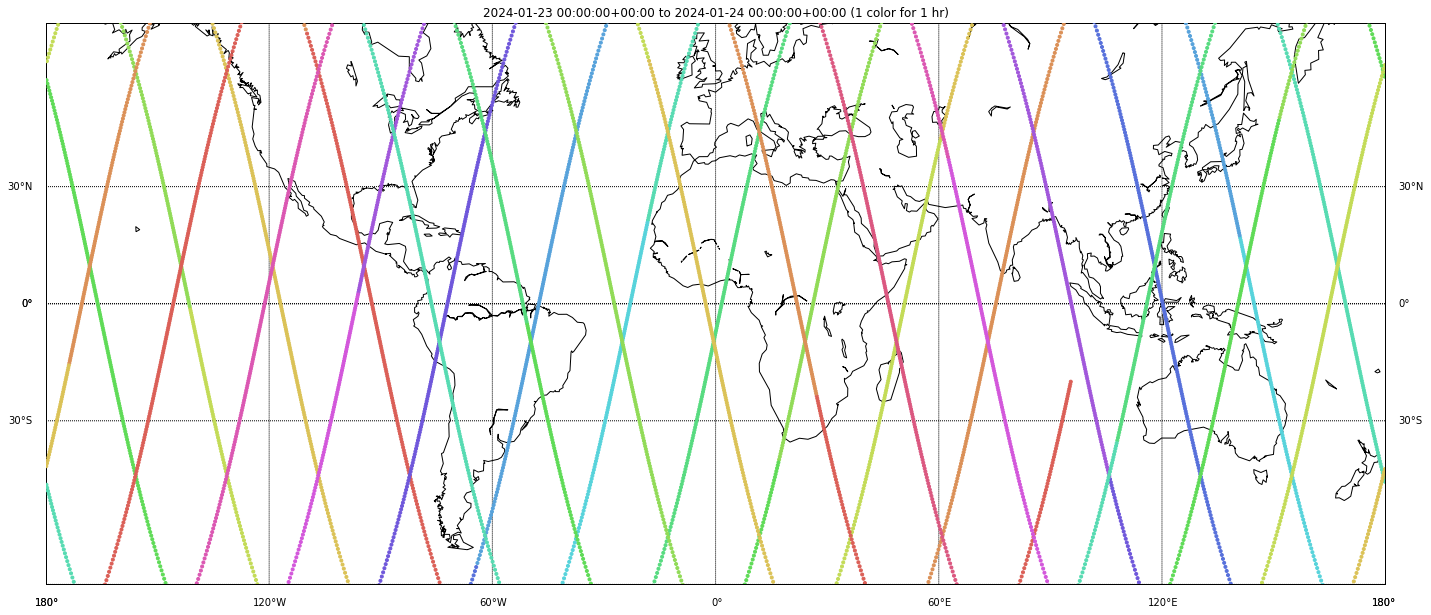

In [12]:
# Hinode
datetime_start=datetime.datetime(2024,1,23,0,0,0, tzinfo=datetime.timezone.utc)
datetime_end=datetime.datetime(2024,1,24,0,0,0, tzinfo=datetime.timezone.utc)
tstep=10.0 # seconds
cstep=60*60 # seconds
norad_num=29479
plot_map(norad_num, datetime_start, datetime_end, tstep, cstep)